In [4]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

# Módulo de XGBoost
from xgboost import XGBRegressor

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

import sys 
sys.path.append("../")
from src.soporte_metricas import (
    obtener_metricas,
    residual_plot,
    generar_df_comparador
)
pd.options.display.float_format = "{:,.2f}".format

In [5]:
df = pd.read_csv("../datos/06_autorenew_target_encoded.csv",index_col=0)

# XG Boost (eXtreme Gradient Boosting)
### Parámetros
- n_estimators: Número de árboles en el modelo
    - Cuantos más, habrá más precisión
- learning_rate: Velocidad de aprendizaje
    - 0.01: Lento y estable
    - 0.1: Equilibrado
    - 0.2: Rápido y riesgoso
- max_depth: Profundidad máxima del árbol
    - 3: 3 niveles de decisión
    - 5: 5 niveles, más profundo y detallado
    - A más profundo, más precisión
- min_child_weight: Peso mínimo necesario para dividir un nodo (similar a min_samples_leaf)
    - 1: Divisiones con muy pocos datos
    - 4: Requiere al menos 4 datos por nodo
- subsample: Proporción de datos que se usa para entrenar a los árboles (muestra aleatoria) es como el train, test split
    - 0.7 para 0.7 Train y 0.3 Test
- colsample_bytree: Proporción de características (columnas) que se seleccionan aleatoriamente para cada árbol
    - 0.8: Usar el 80% de las columnas.


In [6]:
X = df.drop(columns="price")
y = df[["price"]]
X_train, X_test, y_train, y_test = train_test_split(X, # Todo menos la Variable Respuesta
                                                    y, # La variable Respuesta
                                                    train_size=0.7, # Como dividir los datos en este caso 80% train, 20% test
                                                    random_state=42, # Semilla, para que lo haga igual para cualquier persona
                                                    shuffle=True 
                                                    )

In [7]:
# Parámetros a evaluar
params_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 4],  # Equivalente a min_samples_leaf
    'subsample': [0.8, 1.0],        # Para evitar sobreajuste
    'colsample_bytree': [0.8, 1.0]  # Selección de columnas al construir cada árbol
}
modelo_xgb = XGBRegressor(random_state=42,  eval_metric='rmse')

grid_search_xgb = GridSearchCV(XGBRegressor(random_state=42,  eval_metric='rmse'),
                                 param_grid= params_xgb,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 n_jobs=-1)


grid_search_xgb.fit(X_train, y_train.to_numpy().ravel())
modelo_final_xgb = grid_search_xgb.best_estimator_


In [8]:
modelo_final_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Vemos las métricas

In [9]:
y_pred_test = modelo_final_xgb.predict(X_test)
y_pred_train = modelo_final_xgb.predict(X_train)

resultados_xgb= obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
resultados_xgb

,r2_score,MAE,MSE,RMSE
train,0.82,"1,806.98","10,288,246.83","3,207.53"
test,0.80,"1,819.44","10,575,598.88","3,252.01"


# Pasamos los resultados a un DF

In [10]:
# Resultados del GridSearchCV
resultados_xgb = pd.DataFrame(grid_search_xgb.cv_results_)

# Extraemos el impacto de los parámetros

In [11]:
# Extraer el impacto de cada parámetro principal
impacto_xgb = resultados_xgb[['param_n_estimators', 'param_learning_rate', 
                              'param_max_depth', 'param_min_child_weight', 
                              'param_subsample', 'param_colsample_bytree', 
                              'mean_test_score']]
impacto_xgb['mean_test_score'] = -impacto_xgb['mean_test_score']  # Convertir a MSE positivo


# Visualizamos el impacto de cada parámetro

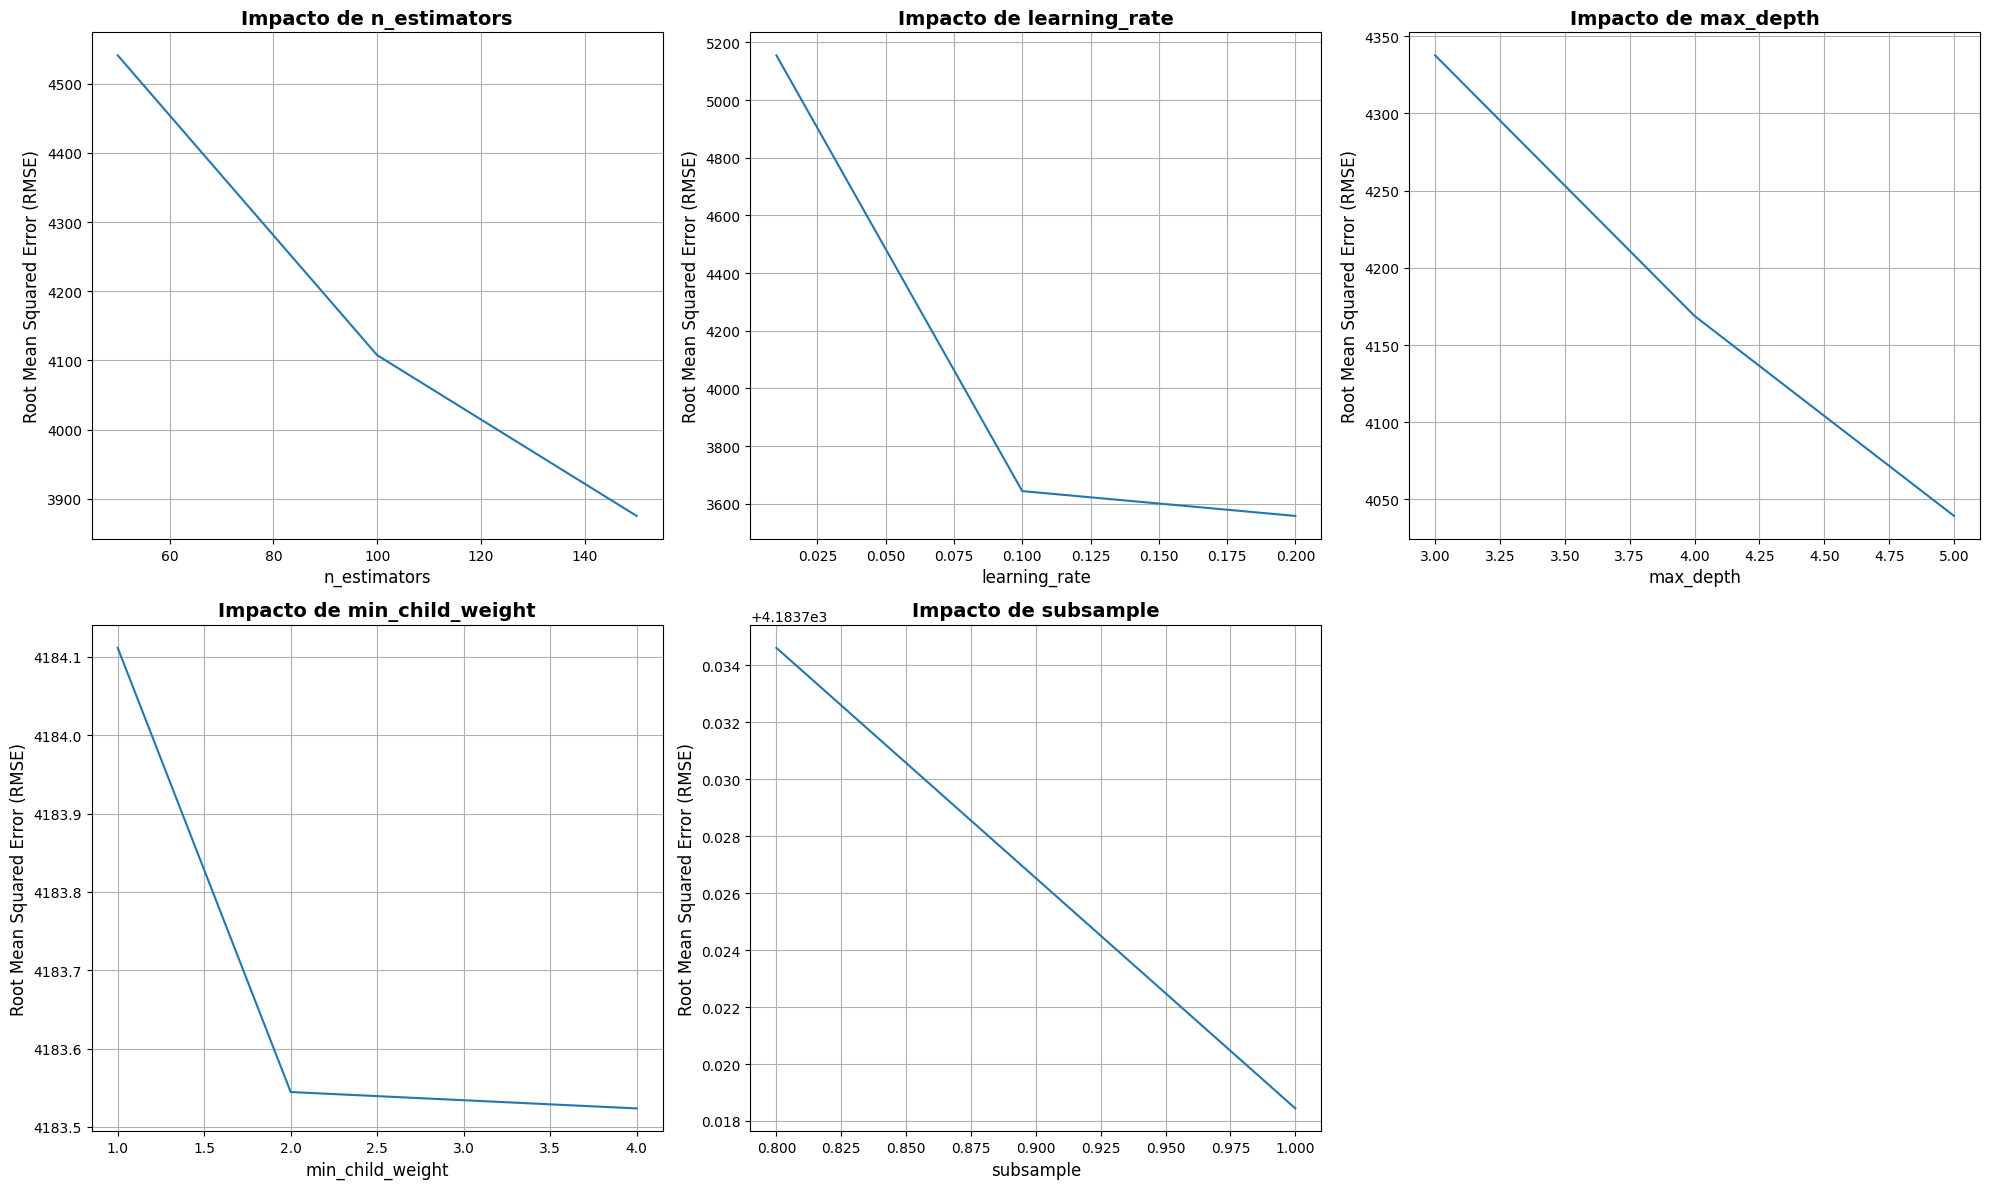

In [12]:
# Visualización del impacto de cada parámetro
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.flat
parametros_xgb = impacto_xgb.columns[:-1]
titulos_xgb = ['Impacto de n_estimators', 'Impacto de learning_rate',
               'Impacto de max_depth', 'Impacto de min_child_weight',
               'Impacto de subsample', 'Impacto de colsample_bytree']

for indice, columns in enumerate(parametros_xgb):
    df_resultados_xgb = impacto_xgb.groupby(columns)['mean_test_score'].mean().reset_index()
    df_resultados_xgb['sqrt_mean_test_score'] = np.sqrt(df_resultados_xgb['mean_test_score'])
    sns.lineplot(x=columns, y="sqrt_mean_test_score", data=df_resultados_xgb, ax=axs[indice])
    axs[indice].set_title(titulos_xgb[indice], fontsize=14, fontweight='bold')
    axs[indice].set_xlabel(columns.replace('param_', ''), fontsize=12)
    axs[indice].set_ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
    axs[indice].grid(True)

fig.delaxes(axs[-1])
plt.tight_layout()
plt.show()

# Otros Modelos de Ensamble
### Bagging
- **Random Forest:** Reduce Varianza, ideal para modelos inestables.
- **Bagged Trees:** Reduce Varianza y mejora la estabilidad del modelo base.
- **Random Subspace Method:** Promueve diversidad, útil en datasets con alta dimensionalidad.
### Boosting
- **AdaBoost:** Reduce Sesgo, ideal para datos con ruido, propenso al sobreajuste
- **Gradient Boosting:** Alta Precisión, sensible al ruido, requiere ajuste cuidadoso
- **XGBoost:** Más rápido manejar valores faltantes automáticos, acepta nulos 
- **LightGBM:** Muy eficiente para grandes volúmenes de datos, requiere menos memoria.
### Voting
- **Hard Voting:** Fácil de implementar, combina diferentes tipos de modelos, robusto frente al ruido
- **Soft Voting:** Parecido al Hard, pero más adecuado a modelos que generan probabilidades
### Stacking
- **Stacked Generalization:** Muy flexible, permite combinar arquitecturas completamente diferentes
- **Blending:** Más rápido, pero menos robusto
### Weighted Ensembles
- **Weighted Voting**: Prioriza modelos más precisos, útil cuando los modelos base tienen desempeños variados
### Bayesian Ensembles
- **Bayesian Model Averaging**: Más teórico, útil para problemas probabilísticos y con incertidumbre en predicciones
### Bag of Features
- **Rotation Forest**: Excelente para problemas de clasificación con alta dimensionalidad, mejora la diversidad
### Cascading
- **Cascade Forest**: Alternativa no neuronal para problemas complejos, útil para datasets tabulares